# 多模式与多任务

In [1]:
import numpy as np

import autokeras as ak
import tensorflow as tf

在本教程中，我们将使用 AutoModel API 来展示如何处理多模态数据和多任务。

In [2]:
gpus = tf.config.list_physical_devices("GPU")

if gpus:
   
    gpu0 = gpus[1] #如果有多个GPU，仅使用第0个GPU
    tf.config.experimental.set_memory_growth(gpu0, True) #设置GPU显存用量按需使用
    # 或者也可以设置GPU显存为固定使用量(例如：4G)
    #tf.config.experimental.set_virtual_device_configuration(gpu0,
    #    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]) 
    tf.config.set_visible_devices([gpu0],"GPU") 

## 什么是多模态？

多模态数据意味着每个数据实例都有多种形式的信息。 例如，可以将照片另存为图像。 除了图像，它也可能有它被取的时间和地点作为其属性，可以表示为结构化数据。

## 什么是多任务？

多任务这里我们指的是我们要预测具有相同输入特征的多个目标。 例如，我们不仅要根据其内容对图像进行分类，还要将其质量回归为介于 0 和 1 之间的浮点数。

下图显示了多模态和多任务神经网络模型的示例。

![](https://tva1.sinaimg.cn/large/008i3skNly1gs9p2h6ou7j30la0fa75a.jpg)

它有两个输入图像和结构化数据。 每个图像都与结构化数据中的一组属性相关联。 从这些数据中，我们试图同时预测分类标签和回归值。

## 数据准备

为了说明我们的想法，我们生成一些随机图像和结构化数据作为多模态数据。

In [3]:
num_instances = 100
# Generate image data.
image_data = np.random.rand(num_instances, 32, 32, 3).astype(np.float32)
# Generate structured data.
structured_data = np.random.rand(num_instances, 20).astype(np.float32)

In [4]:
image_data.shape

(100, 32, 32, 3)

我们还为分类和回归生成了一些多任务目标。

In [5]:
# Generate regression targets.
regression_target = np.random.rand(num_instances, 1).astype(np.float32)
# Generate classification labels of five classes.
classification_target = np.random.randint(5, size=num_instances)

In [6]:
classification_target.shape

(100,)

## 构建和训练模型

然后我们用 AutoModel 初始化多模态多任务模型。 由于这只是一个演示，我们使用了少量的 max_trials 和 epochs。

In [7]:
# Initialize the multi with multiple inputs and outputs.
model = ak.AutoModel(
    inputs=[ak.ImageInput(), ak.StructuredDataInput()],
    outputs=[
        ak.RegressionHead(metrics=["mae"]),
        ak.ClassificationHead(loss="categorical_crossentropy", metrics=["accuracy"]),
    ],
    overwrite=True,
    max_trials=2,
)

In [8]:
# Fit the model with prepared data.
model.fit(
    [image_data, structured_data],
    [regression_target, classification_target],
    epochs=3,
)

Trial 2 Complete [00h 00m 44s]
val_loss: 1.7933752536773682

Best val_loss So Far: 1.7116538286209106
Total elapsed time: 00h 01m 38s
INFO:tensorflow:Oracle triggered exit
Epoch 1/3
4/4 [==============================] - 13s 1s/step - loss: 13.3310 - regression_head_1_loss: 9.8872 - classification_head_1_loss: 3.4438 - regression_head_1_mae: 2.5708 - classification_head_1_accuracy: 0.2300
Epoch 2/3
4/4 [==============================] - 0s 92ms/step - loss: 38.2598 - regression_head_1_loss: 34.9258 - classification_head_1_loss: 3.3340 - regression_head_1_mae: 3.0301 - classification_head_1_accuracy: 0.2000
Epoch 3/3
4/4 [==============================] - 0s 96ms/step - loss: 26.0175 - regression_head_1_loss: 23.8023 - classification_head_1_loss: 2.2152 - regression_head_1_mae: 2.9589 - classification_head_1_accuracy: 0.2700


/public/huangwei/miniconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


## 验证数据

默认情况下，AutoKeras 使用最后 20% 的训练数据作为验证数据。 如下例所示，您可以使用validation_split 来指定百分比。

In [9]:
model.fit(
    [image_data, structured_data],
    [regression_target, classification_target],
    # Split the training data and use the last 15% as validation data.
    validation_split=0.15,
    epochs=2,
)

您还可以使用您自己的验证集，而不是使用validation_data 将其从训练数据中分离出来。

In [11]:
split = 20

image_val = image_data[split:]
structured_val = structured_data[split:]
regression_val = regression_target[split:]
classification_val = classification_target[split:]

In [12]:
image_data = image_data[:split]
structured_data = structured_data[:split]
regression_target = regression_target[:split]
classification_target = classification_target[:split]

In [13]:
model.fit(
    [image_data, structured_data],
    [regression_target, classification_target],
    # Use your own validation set.
    validation_data=(
        [image_val, structured_val],
        [regression_val, classification_val],
    ),
    epochs=2,
)

## 自定义搜索空间

您可以自定义搜索空间。 下图显示了我们要定义的搜索空间。

![](https://tva1.sinaimg.cn/large/008i3skNly1gs9pt84zvjj313a07wq40.jpg)

In [14]:
input_node1 = ak.ImageInput()
output_node = ak.Normalization()(input_node1)
output_node = ak.ImageAugmentation()(output_node)
output_node1 = ak.ConvBlock()(output_node)
output_node2 = ak.ResNetBlock(version="v2")(output_node)
output_node1 = ak.Merge()([output_node1, output_node2])

input_node2 = ak.StructuredDataInput()
output_node = ak.CategoricalToNumerical()(input_node2)
output_node2 = ak.DenseBlock()(output_node)

output_node = ak.Merge()([output_node1, output_node2])
output_node1 = ak.ClassificationHead()(output_node)
output_node2 = ak.RegressionHead()(output_node)

In [26]:
auto_model = ak.AutoModel(
    inputs=[input_node1, input_node2],
    outputs=[output_node1, output_node2],
    overwrite=True,
    max_trials=10,
)

In [17]:
image_data = np.random.rand(num_instances, 32, 32, 3).astype(np.float32)
structured_data = np.random.rand(num_instances, 20).astype(np.float32)
regression_target = np.random.rand(num_instances, 1).astype(np.float32)
classification_target = np.random.randint(5, size=num_instances)

In [27]:
auto_model.fit(
    [image_data, structured_data],
    [classification_target, regression_target],
    batch_size=32,
    epochs=3,
)

Trial 10 Complete [00h 00m 23s]
val_loss: 1.547892451286316

Best val_loss So Far: 1.2751150131225586
Total elapsed time: 00h 04m 50s
INFO:tensorflow:Oracle triggered exit
Epoch 1/3
4/4 [==============================] - 6s 226ms/step - loss: 2.4339 - classification_head_1_loss: 1.6282 - regression_head_1_loss: 0.8057 - classification_head_1_accuracy: 0.3100 - regression_head_1_mean_squared_error: 0.8057
Epoch 2/3
4/4 [==============================] - 0s 57ms/step - loss: 2.3027 - classification_head_1_loss: 1.6652 - regression_head_1_loss: 0.6376 - classification_head_1_accuracy: 0.3300 - regression_head_1_mean_squared_error: 0.6376
Epoch 3/3
4/4 [==============================] - 0s 54ms/step - loss: 1.7111 - classification_head_1_loss: 1.3983 - regression_head_1_loss: 0.3128 - classification_head_1_accuracy: 0.4200 - regression_head_1_mean_squared_error: 0.3128


/public/huangwei/miniconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


In [19]:
from tensorflow.keras.utils import plot_model

In [28]:
model = auto_model.export_model()

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
cast_to_float32 (CastToFloat32) (None, 32, 32, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 32, 32, 3)    7           cast_to_float32[0][0]            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 20)]         0                                            
______________________________________________________________________________________________

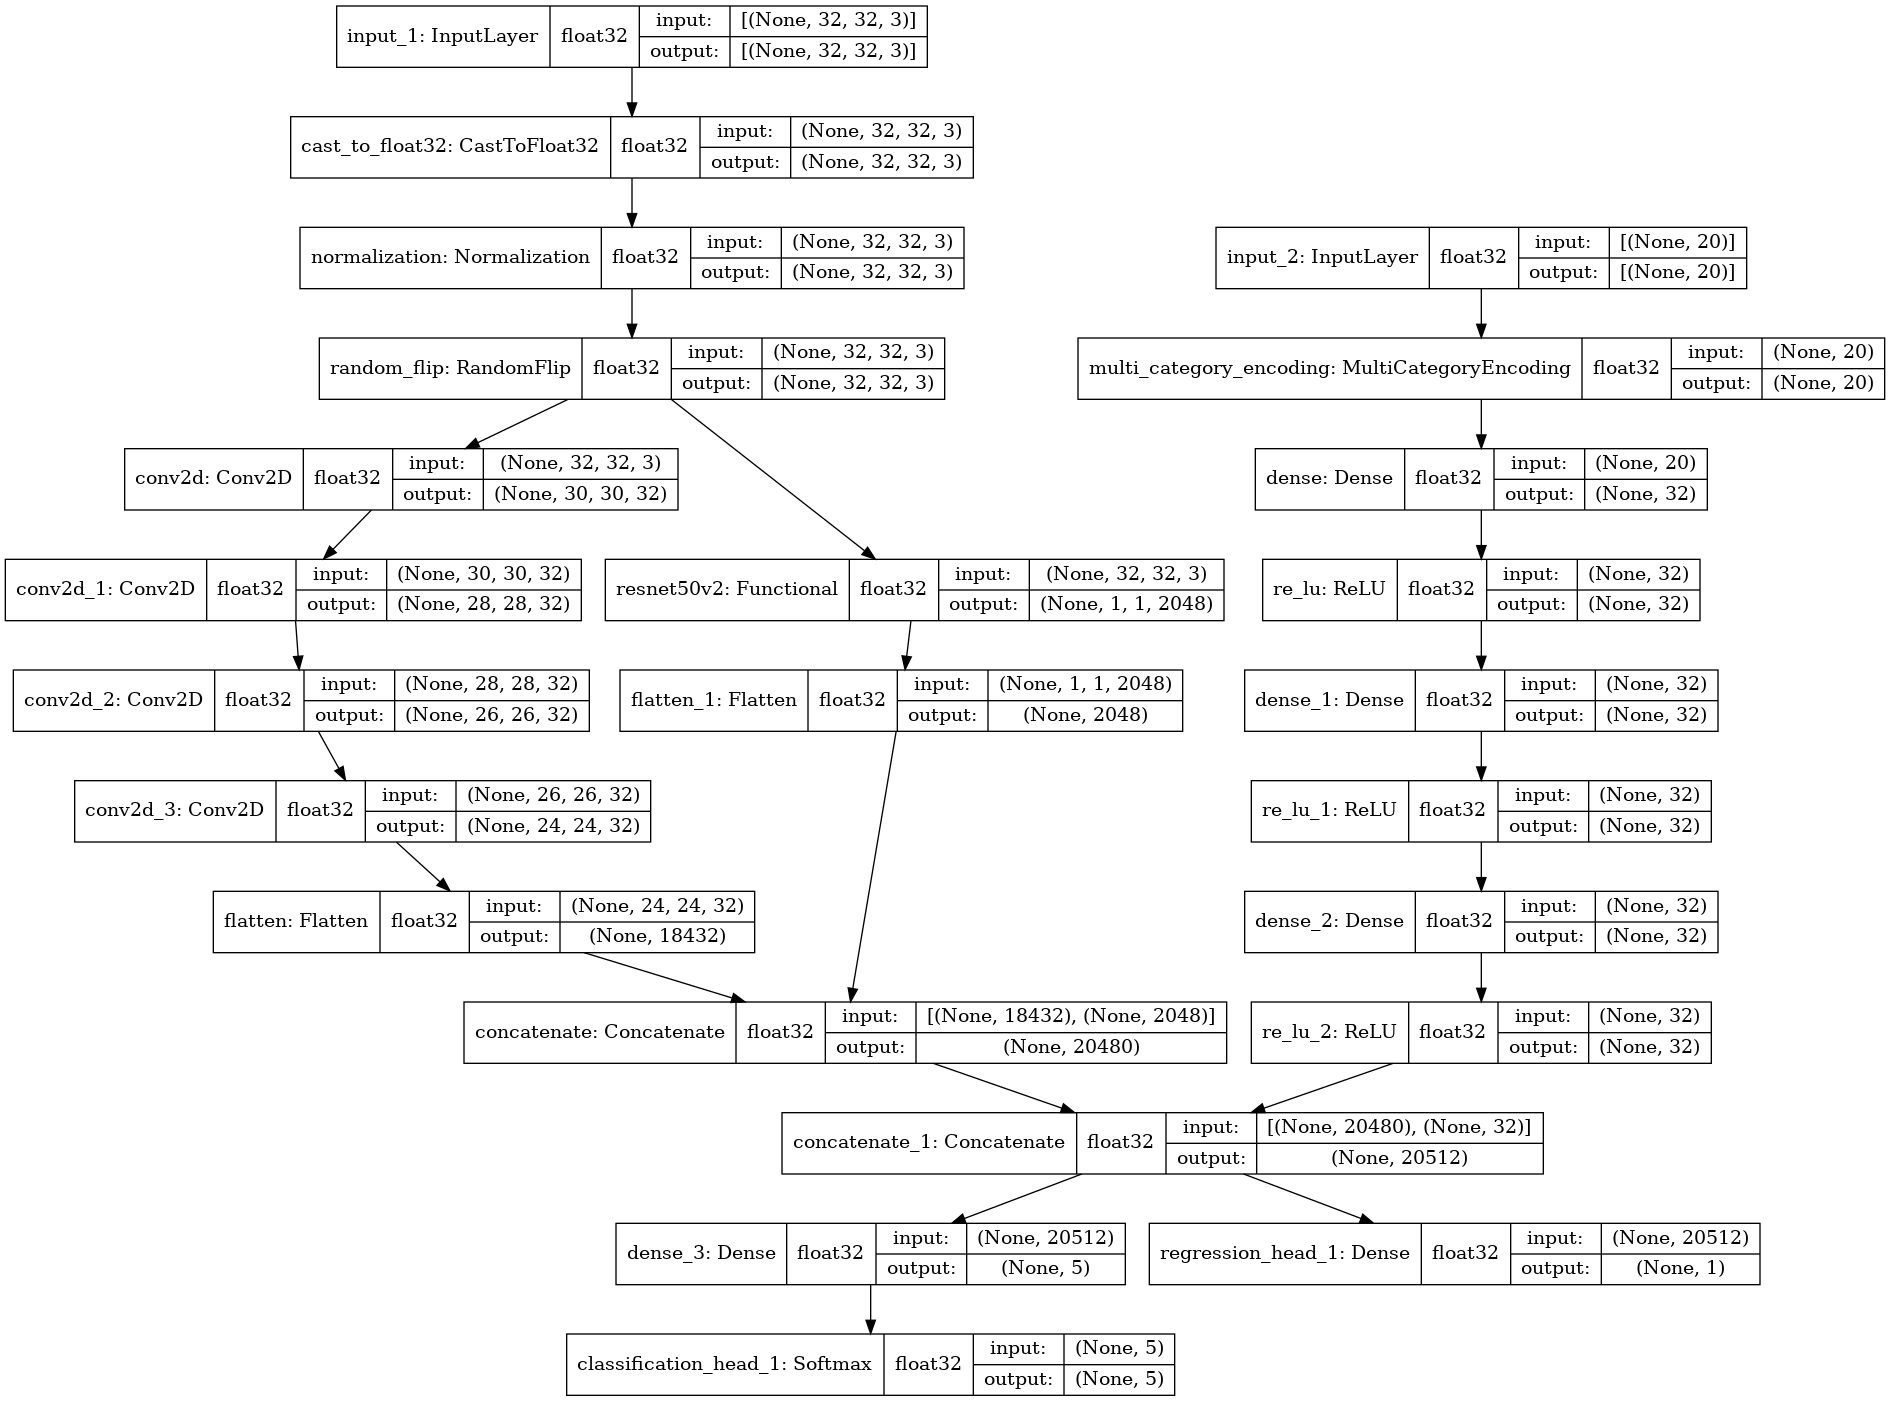

In [30]:
plot_model(model, show_shapes=True, show_dtype=True,show_layer_names=True)

## 数据格式

不同类型数据的格式可以参考ImageInput、StructuredDataInput、TextInput、RegressionHead、ClassificationHead的文档。 也可以参考图像分类、文本分类、结构化数据分类教程的数据格式部分。